In [1]:
from trafficintelligence import storage, moving

objects = storage.loadTrajectoriesFromSqlite('Donnees/1014AM_July 11_2014(E to W).sqlite','feature',5)

# alignmentEW = cvutils.projectArray(homography, np.array([(1933.4388356669124, 753.81466470154737),
#                                                          (85.58495394,  461.14790174)]).T)

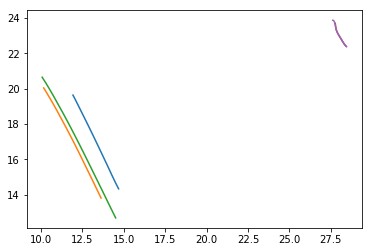

In [2]:
for o in objects:
    o.plot()

In [3]:
frameRate = 30 #30000/1001.
frameNumber = 21
speed = objects[1].getVelocityAtInstant(frameNumber-1)
# speed = (frameRate*speed[0], frameRate*speed[1])
# speed

In [4]:
print("%f"%speed.norm2())

0.369300


In [5]:
pos = objects[0].getPositionAtInstant(10)
pos

(13.238100,17.189600)

In [6]:
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon

In [7]:
# https://gist.github.com/pv/8036995
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [8]:
points = np.array([[0,0]])

for o in objects:
    pos = o.getPositionAtInstant(10)
    points = np.append(points, [[pos[0],pos[1]]], axis = 0) 

points = points[1:]

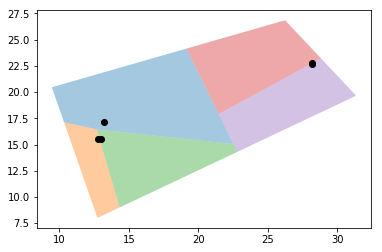

In [9]:
# https://stackoverflow.com/questions/36063533/clipping-a-voronoi-diagram-python?noredirect=1&lq=1
# compute Voronoi tesselation
vor = Voronoi(points)

regions, vertices = voronoi_finite_polygons_2d(vor)

min_x = 9.45423
max_x = 31.3422
min_y = 7.99941
max_y = 26.8535

mins = np.tile((min_x, min_y), (vertices.shape[0], 1))
bounded_vertices = np.max((vertices, mins), axis=0)
maxs = np.tile((max_x, max_y), (vertices.shape[0], 1))
bounded_vertices = np.min((bounded_vertices, maxs), axis=0)

box = Polygon([[12.7377, min_y], [min_x, 20.4617], [26.2292, max_y], [max_x, 19.6558]])

# colorize
for region in regions:
    polygon = vertices[region]
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    polygon = [p for p in poly.exterior.coords]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points[:, 0], points[:, 1], 'ko')

plt.show()

In [10]:
# https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
def PolygonArea(corners):
    n = len(corners) # of corners
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

# examples
corners = [(2.0, 1.0), (4.0, 5.0), (7.0, 8.0)]

print(PolygonArea(polygon))

38.68800594183941


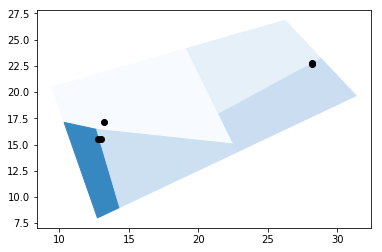

In [11]:
# https://stackoverflow.com/questions/41244322/how-to-color-voronoi-according-to-a-color-scale-and-the-area-of-each-cell
import matplotlib as mpl
import matplotlib.cm as cm

# area = np.random.uniform(low = 0.0, high = 5.0, size = 5)
# find min/max values for normalization
minima = 0
maxima = 50

# normalize chosen colormap
norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues_r)

i = 0

# colorize
for region in regions:
    polygon = vertices[region]
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    polygon = [p for p in poly.exterior.coords]
    plt.fill(*zip(*polygon), color = mapper.to_rgba(PolygonArea(polygon)))
    i += 1

plt.plot(points[:, 0], points[:, 1], 'ko')

plt.show()